## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Install Required Libraries

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pycaret --user

### Loading data

In [21]:
import pandas as pd
import time

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/TIV/'
filename = path + 'Dataset.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 0.058988 seconds.


In [22]:
df.set_index('TIME', inplace=True)

In [23]:
df

,Unemployment_rate,CCI,CPI,LT_interest_rates,TIV
TIME,,,,,
1999-01,10.7,100.80970,0.496834,3.910000,16486
1999-02,10.6,100.77260,0.760012,4.040000,10914
1999-03,10.5,100.91180,0.787555,4.260000,13857
1999-04,10.4,101.18520,1.064654,4.070000,15360
1999-05,10.3,101.48840,1.365353,4.240000,14173
...,...,...,...,...,...
2022-08,7.2,94.49490,7.616082,1.624904,8163
2022-09,7.3,94.14937,8.119296,2.420836,7867
2022-10,6.4,94.09906,8.310766,2.894486,7132


In [24]:
# Data statistics
df.describe()

,Unemployment_rate,CCI,CPI,LT_interest_rates,TIV
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,8.274653,99.885023,1.697493,2.619576,11012.440972
std,1.065037,1.705883,1.676572,1.852456,3005.347815
min,5.700000,94.099060,-1.551095,-0.410000,2969.000000
25%,7.575000,98.877555,0.643463,0.697500,9107.250000
50%,8.400000,100.274550,1.258261,3.035000,10687.500000
75%,9.000000,100.988800,2.580199,4.165000,12635.250000
max,10.700000,102.737500,9.145037,5.740000,25629.000000


In [25]:
df.isna().sum()

Unemployment_rate    0
CCI                  0
CPI                  0
LT_interest_rates    0
TIV                  0
dtype: int64

### Plotting data

Time series decomposition is a process by which we separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

In [26]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import plotly.graph_objs as go

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
        .update_xaxes(
            dtick="M6",
            tickformat="%b\n%Y"
        )        
    )

decomposition = seasonal_decompose(df['TIV'], model='additive', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

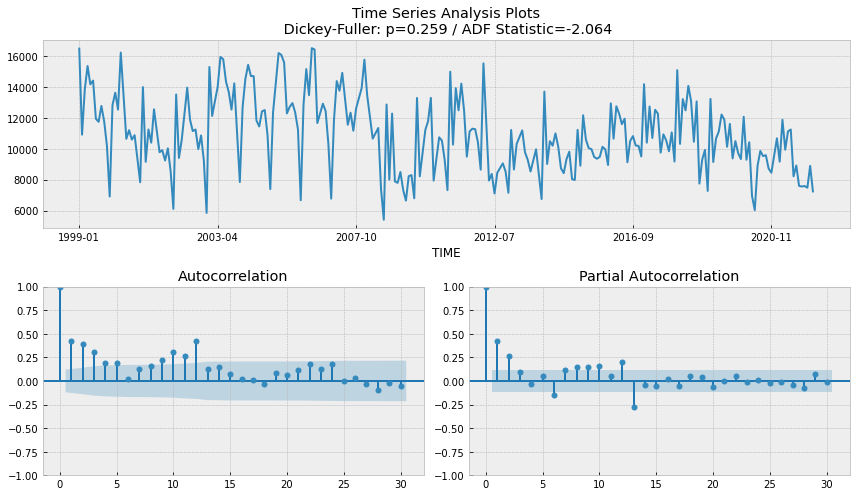

In [77]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = sm.tsa.stattools.adfuller(y)
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
tsplot(df.TIV, lags=30)

This results in an ADF statistic of –2.064 and a p-value of 0.259. Here, the ADF statistic is not a large negative number, and the p-value is greater than 0.05. Therefore, our time series is not stationary, and we must apply transformations to make it stationary.

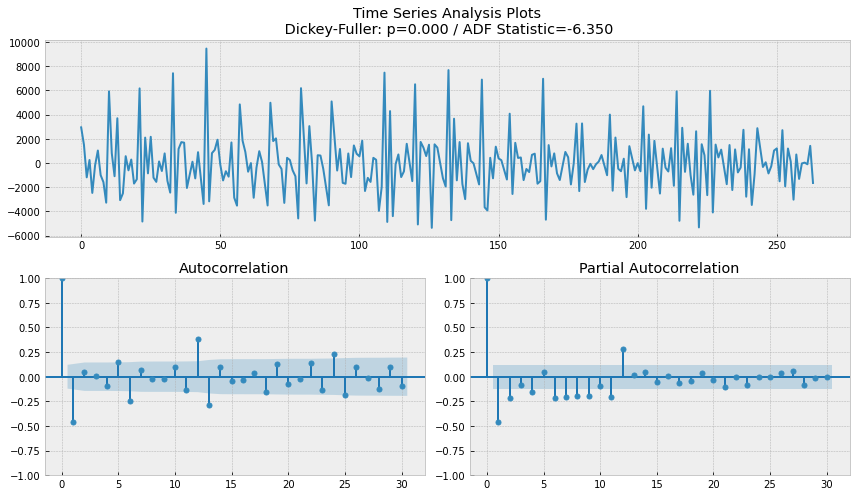

In [79]:
# Take the first difference to remove to make our series stationary
#data_diff = df.TIV - df.TIV.shift(1)
import numpy as np
data_diff = np.diff(df.TIV,1)
tsplot(data_diff[1:], lags=30)

This gives an ADF statistic of –6.350 and a p-value of 0.000. Therefore, with a larger negative ADF statistic and a p-value smaller than 0.05, we can say that our series is now stationary.

Looking at the autocorrelation plot, we notice that there are significant coefficients up until lag 2. Then they abruptly become non-significant, as they remain in the shaded area of the plot. This means that we have a stationary moving average process of order 2. We can use a second-order moving average model, or MA(2) model, to forecast our stationary time series.

In [97]:
df_diff = pd.DataFrame({'TIV_diff': data_diff}) 
train = df_diff[:int(0.8*len(df_diff))]
test = df_diff[int(0.8*len(df_diff)):] 
print(len(df_diff))
print(len(train))
print(len(test))

265
212
53


In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list: 
    total_len = train_len + horizon 
    if method == 'mean': 
        pred_mean = [] 
        for i in range(train_len, total_len, window): 
            mean = np.mean(df[:i].values) 
            pred_mean.extend(mean for _ in range(window)) 
        return pred_mean 

    elif method == 'last': 
        pred_last_value = [] 
        for i in range(train_len, total_len, window): 
            last_value = df[:i].iloc[-1].values[0] 
            pred_last_value.extend(last_value for _ in range(window)) 
        return pred_last_value 

    elif method == 'MA': 
        pred_MA = [] 
        for i in range(train_len, total_len, window): 
            model = SARIMAX(df[:i], order=(0,0,2)) 
            res = model.fit(disp=False) 
            predictions = res.get_prediction(0, i + window - 1) 
            oos_pred = predictions.predicted_mean.iloc[-window:] 
            pred_MA.extend(oos_pred) 
        return pred_MA

In [98]:
pred_df = test.copy() 
print(pred_df)
TRAIN_LEN = len(train)
HORIZON = len(test)-1
WINDOW = 2 

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA') 

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
#pred_df['pred_MA'] = pred_MA 
pred_df.head()

     TIV_diff
212      -704
213      1221
214     -1884
215      5917
216     -4778
217      2907
218      -734
219      1590
220     -1004
221     -2620
222      2617
223     -5324
224      1546
225       635
226     -2659
227      5963
228     -4090
229      1518
230       458
231      1101
232      -335
233     -1753
234      1481
235     -2236
236      1120
237      -782
238      -379
239      2741
240     -2786
241      1132
242     -3470
243      -926
244      2872
245       961
246      -332
247        56
248      -866
249      -269
250      1026
251      1206
252     -1514
253      2710
254     -1935
255      1191
256       115
257     -3032
258       700
259     -1320
260       -38
261        30
262      -107
263      1413
264     -1653


ValueError: Length of values (52) does not match length of index (53)

array([[<AxesSubplot:title={'center':'Unemployment_rate'}>,
        <AxesSubplot:title={'center':'CCI'}>],
       [<AxesSubplot:title={'center':'CPI'}>,
        <AxesSubplot:title={'center':'LT_interest_rates'}>],
       [<AxesSubplot:title={'center':'TIV'}>, <AxesSubplot:>]],
      dtype=object)

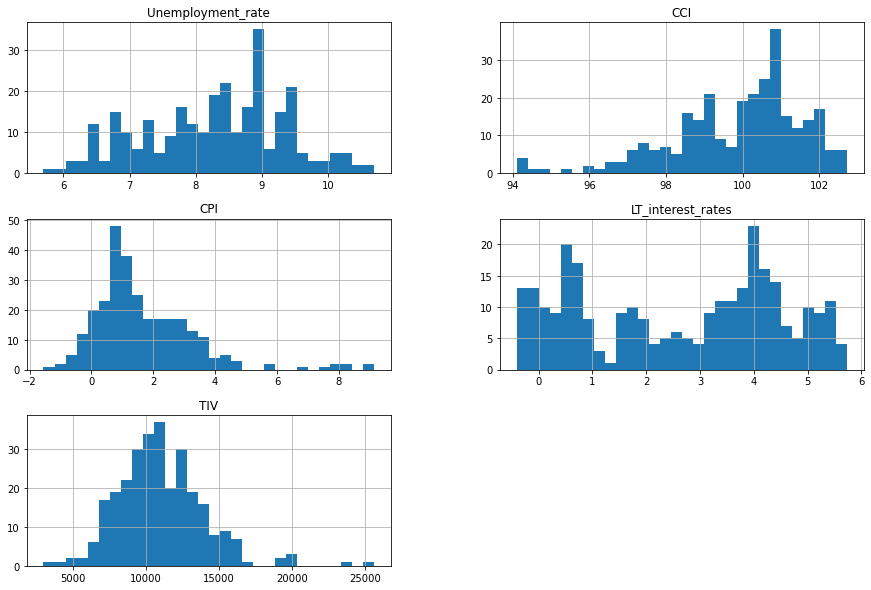

In [27]:
df.hist(bins=30, figsize=(15, 10))

In [28]:
# Removing outliers
df = df[(df['TIV'] < 17000) & (df['TIV'] > 5000)]
df = df[df['CPI'] < 5]

array([[<AxesSubplot:title={'center':'Unemployment_rate'}>,
        <AxesSubplot:title={'center':'CCI'}>],
       [<AxesSubplot:title={'center':'CPI'}>,
        <AxesSubplot:title={'center':'LT_interest_rates'}>],
       [<AxesSubplot:title={'center':'TIV'}>, <AxesSubplot:>]],
      dtype=object)

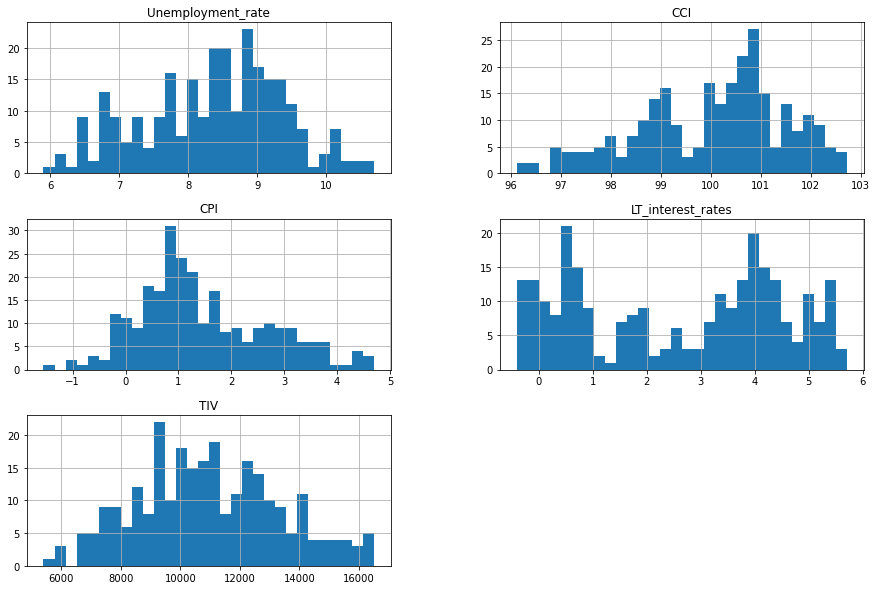

In [29]:
df.hist(bins=30, figsize=(15, 10))

array([[<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>],
       [<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>],
       [<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>],
       [<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>],
       [<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>],
       [<AxesSubplot:xlabel='TIME'>, <AxesSubplot:xlabel='TIME'>]],
      dtype=object)

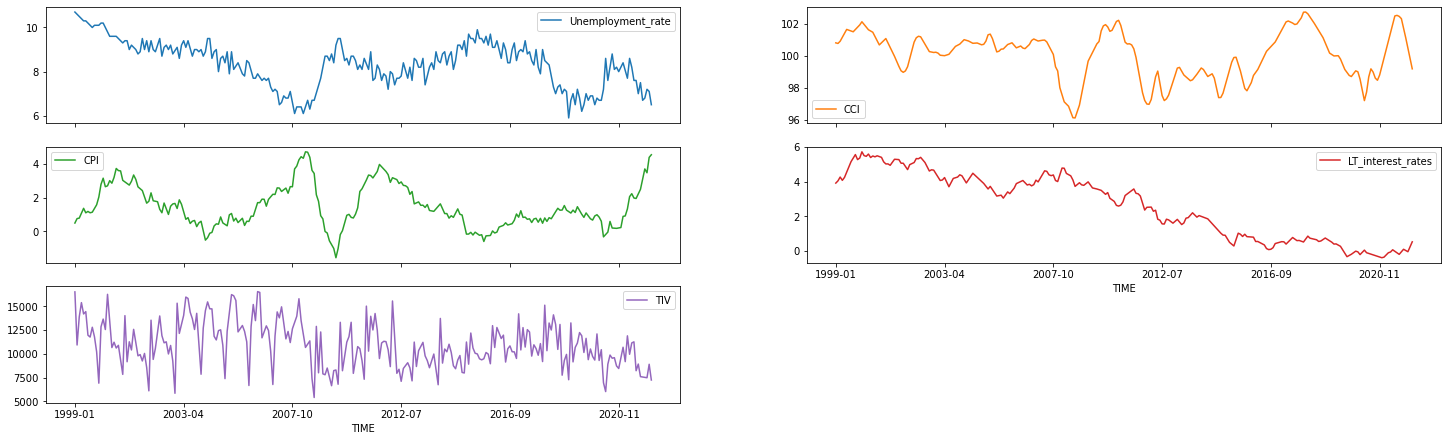

In [30]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams["figure.figsize"] = [25, 15]
df.plot(legend=True, subplots=True, layout=(6,2))

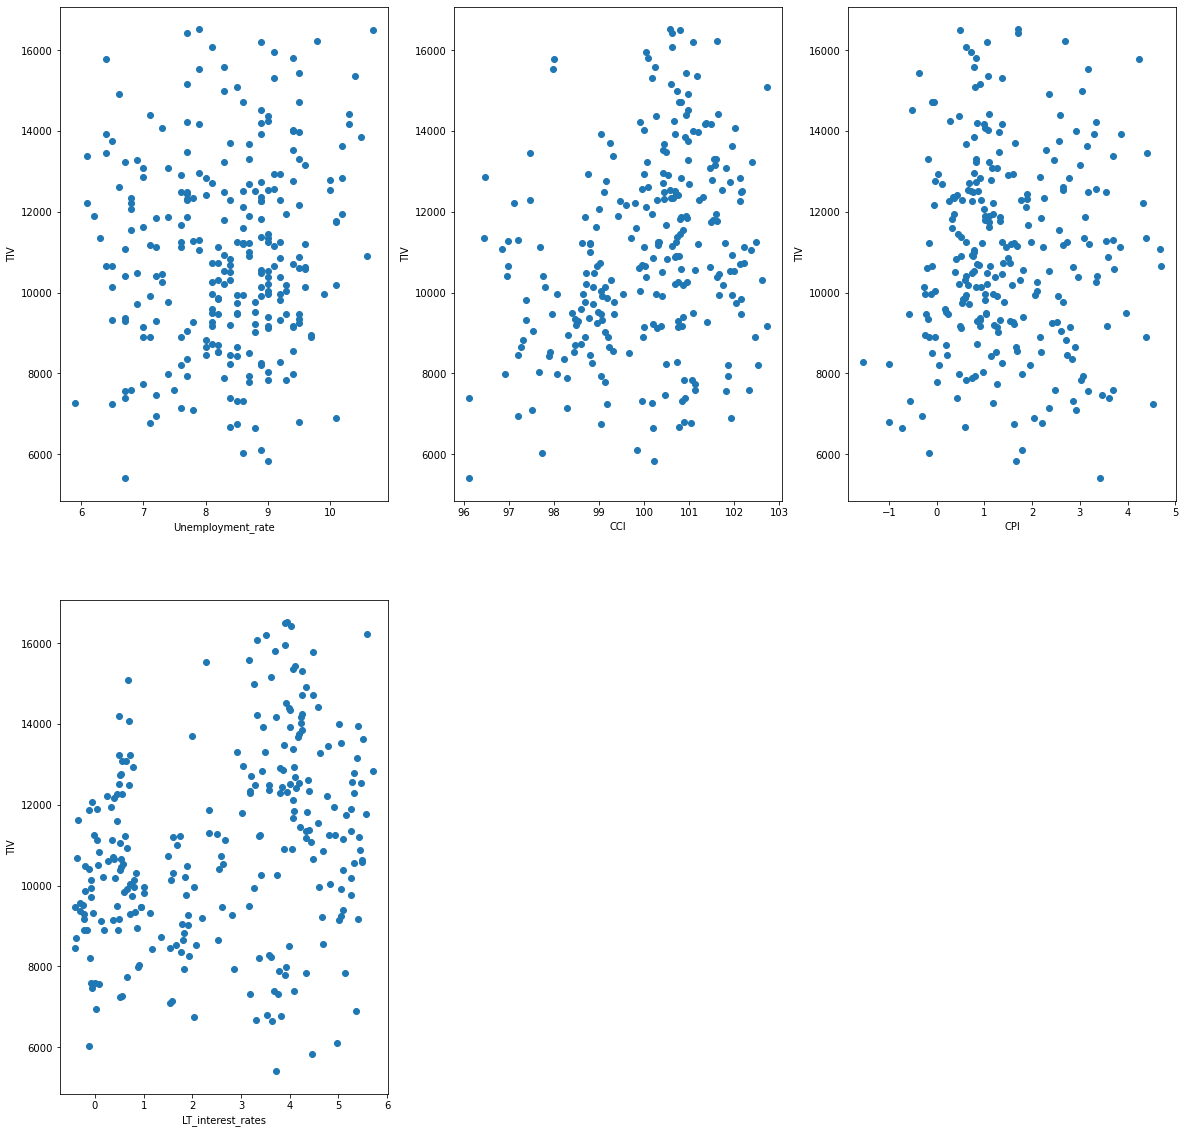

In [31]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):

    dep_var = 'TIV'                          # Dependant variable
    ind_var = df.loc[:, df.columns != 'TIV'] # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(20,20))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(df,3)

<AxesSubplot:>

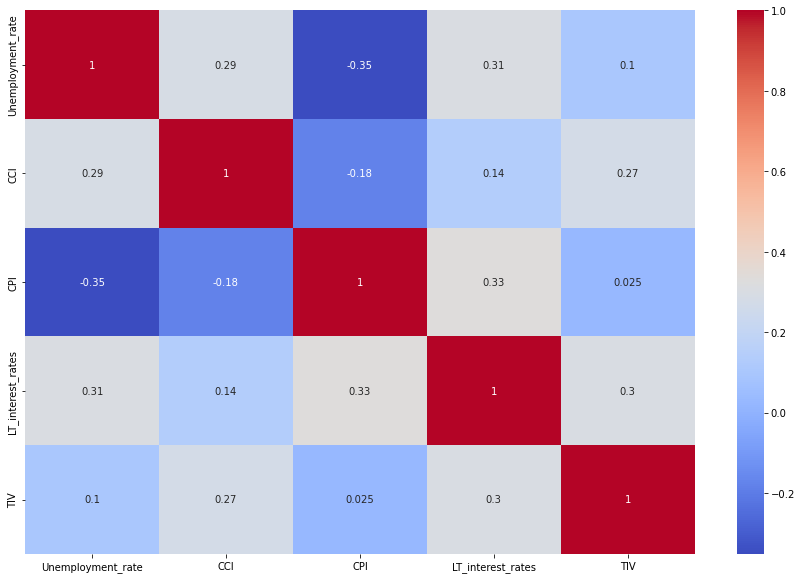

In [32]:
# Import seaborn
import seaborn as sns

# Plot the correlations as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2g')

### Feature Engineering

Creting new variables

In [33]:
df['Month'] = df.index.astype(str).str[-2:]
df['Month'] = df['Month'].astype(int)

In [34]:
df

,Unemployment_rate,CCI,CPI,LT_interest_rates,TIV,Month
TIME,,,,,,
1999-01,10.7,100.80970,0.496834,3.910000,16486,1
1999-02,10.6,100.77260,0.760012,4.040000,10914,2
1999-03,10.5,100.91180,0.787555,4.260000,13857,3
1999-04,10.4,101.18520,1.064654,4.070000,15360,4
1999-05,10.3,101.48840,1.365353,4.240000,14173,5
...,...,...,...,...,...,...
2021-10,6.7,101.82020,3.159619,0.078884,7556,10
2021-11,6.8,101.12920,3.691922,0.004300,7586,11
2021-12,7.2,100.46120,3.465204,-0.061840,7479,12


### Data split

In [55]:
test_size = 0.25
normalization = False

# Select input and target variables
X = df.drop('TIV', axis=1)
y = df["TIV"]

# Split data into train and test sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

# Normalization
from sklearn.preprocessing import StandardScaler
if normalization:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

### Scoring function

In [37]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go

metrics = pd.DataFrame()

def scoring(model_name, model, features, labels):
    
    # Make predictions
    predictions = model.predict(features)
    
    # Calculate metrics
    mae = mean_absolute_error(labels, predictions)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(labels, predictions)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                               # RMSE (Root Mean Squared Error)
    r2 = r2_score(labels, predictions)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((labels - predictions) / labels)) * 100       # MAPE
    accuracy = 100 - mape                                               # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']
    
    # Print metrics    
    print(model_name, 'Model Performance:')                             # Model name
    print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
    print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
    print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
    print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
    print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

    df = pd.DataFrame(labels)
        
    # Plot Actual values vs predicted values
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=df.index, y=labels, mode='lines+markers', name= 'Actual values')))
    fig.add_trace(go.Scatter(dict(x=df.index, y=predictions, mode='lines+markers', name= 'Actual values')))
    fig.update_layout(title=go.layout.Title(
        text='Actual vs Predictions with ' + model_name,
        xref='paper',x=0),
        margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date',font=dict(
        family='Courier New, monospace',
        size=18,
        color='#7f7f7f'))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Retails',font=dict(
        family='Courier New, monospace',
        size=18,
        color='#7f7f7f'))))
    fig.show()    

### XGBoost (Extreme Gradient Boosting)

#### Baseline

In [38]:
import xgboost as xgb

# Check xgboost version
print("XGboost version:", xgb.__version__)

# Import XGBRegressor
from xgboost import XGBRegressor         
          
# Instantiate the regressor
model = XGBRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

XGboost version: 1.7.2
XGBRegressor Model Performance:
Mean Absolute Error: 1521.56.
Mean Squared Error: 3746593.08.
Root Mean Squared Error: 1935.61.
R^2 Score = -0.07.
Mean Absolute Percentage Error: 15.06%.
Accuracy = 84.94%.


In [18]:
# Compute and print model score woth the TRAIN  SET
scoring(model.__class__.__name__, model , X_train, y_train)

XGBRegressor Model Performance:
Mean Absolute Error: 2.34.
Mean Squared Error: 10.71.
Root Mean Squared Error: 3.27.
R^2 Score = 1.00.
Mean Absolute Percentage Error: 0.02%.
Accuracy = 99.98%.


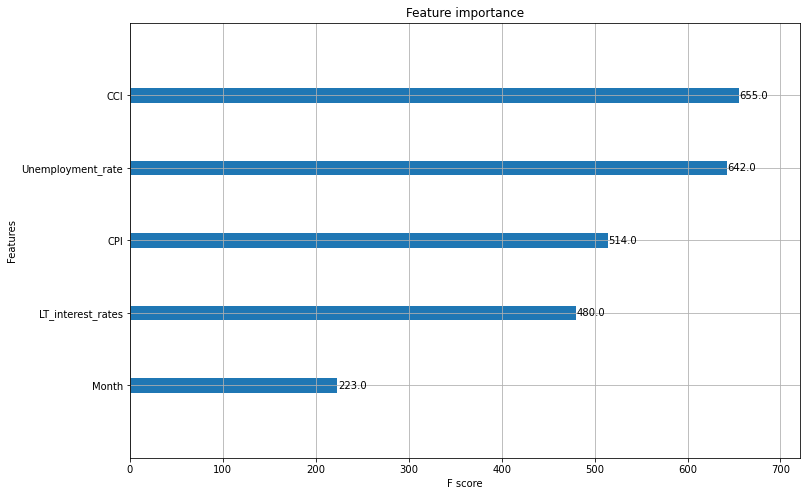

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)
plt.show();

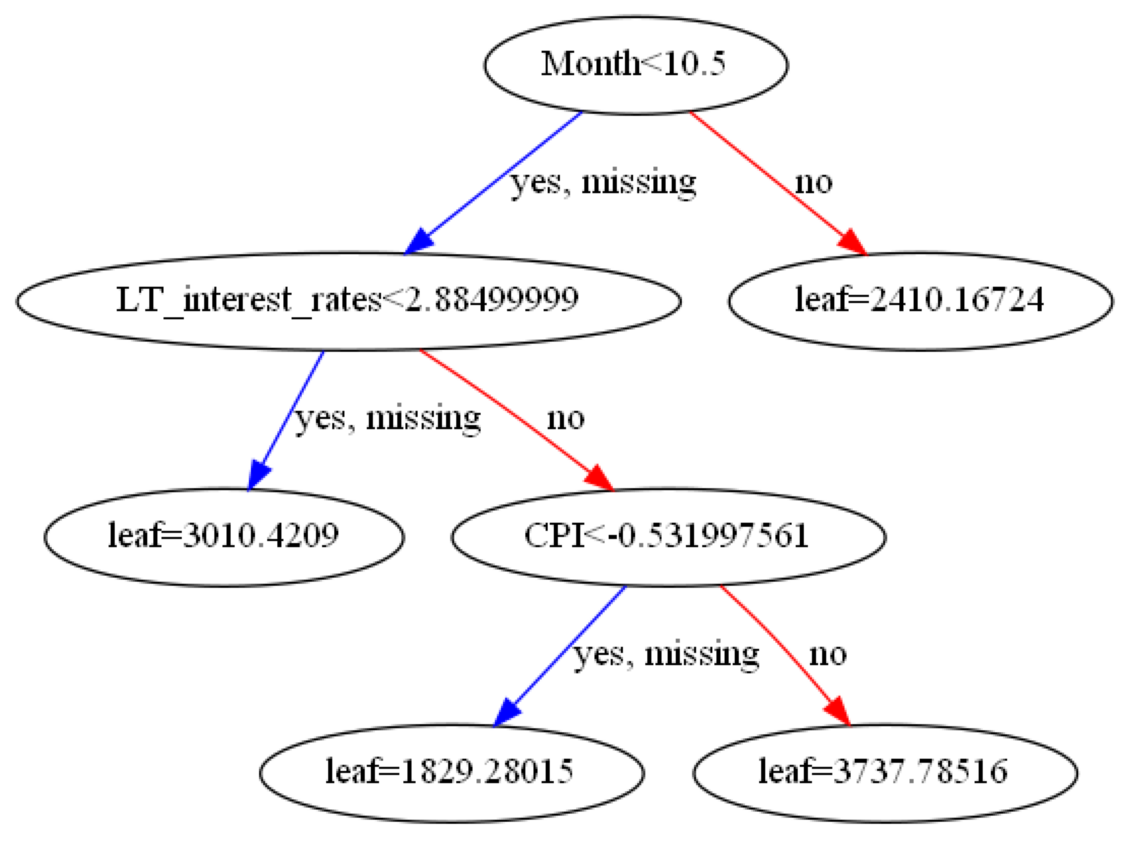

In [20]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax)
plt.show()

In [14]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

#### Hyperparameters Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
xgb_n_estimators = [100, 500, 1000]
xgb_max_depth = [4, 6, 8]
xgb_min_child_weight = [1, 3, 5]
xgb_eta = [0.01, 0.1, 0.2, 0.3]
#xgb_subsample = [0.9, 0.5, 0.2, 0.1]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
param_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'eta': xgb_eta,
#            'subsample': xgb_subsample,
            'objective': xgb_objective}

# Tune the Model
model_base = XGBRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 5, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

 The best score across ALL searched params:
 -0.32944331746962285

 The best parameters across ALL searched params:
 {'eta': 0.01, 'max_depth': 8, 'min_child_

#### Tuned Model

XGBRegressor Tuned
XGBRegressor Tuned Model Performance:
Mean Absolute Error: 2076.2943.
Mean Squared Error: 6628187.8860.
Root Mean Squared Error: 2574.5267.
R^2 Score = -0.7580.
Mean Absolute Percentage Error: 22.7051.
Accuracy = 77.29%.


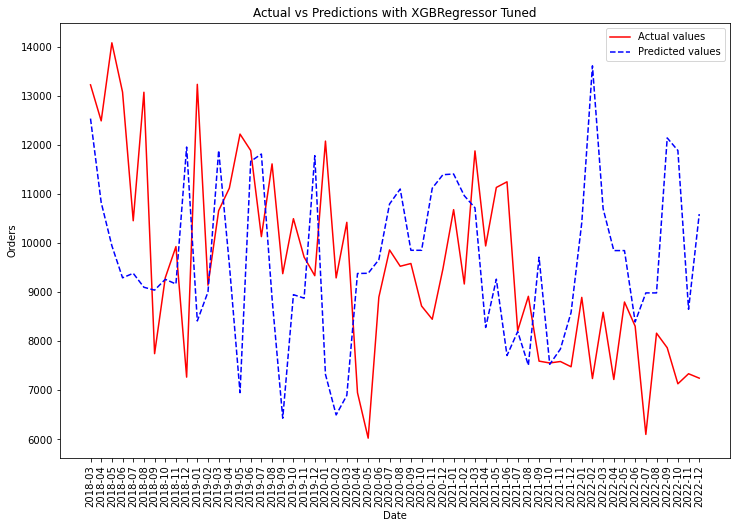

In [16]:
# Create the fnal Extreme Gradient Booster
model_tuned = XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 500,
                         min_child_weight = 5,
                         max_depth = 8,                                                  
                         eta = 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### LightGBM Regression

#### Baseline

LigthGBM version: 3.3.4
LGBMRegressor Model Performance:
Mean Absolute Error: 1737.4058.
Mean Squared Error: 4380019.7783.
Root Mean Squared Error: 2092.8497.
R^2 Score = -0.1617.
Mean Absolute Percentage Error: 18.8912.
Accuracy = 81.11%.


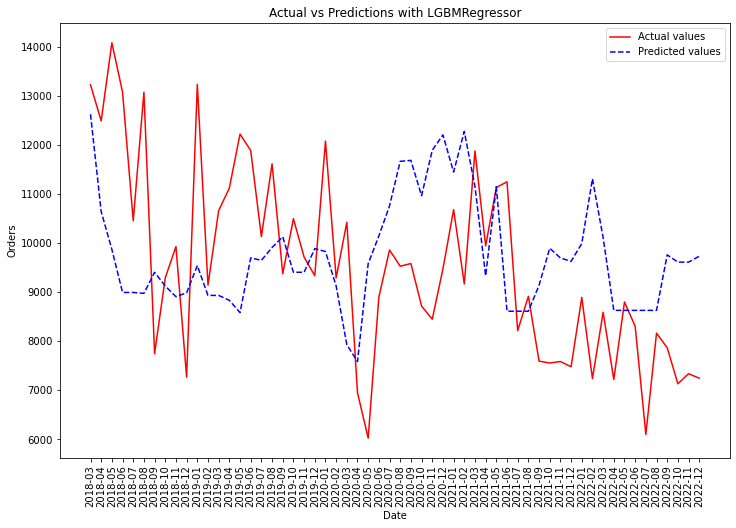

In [17]:
import lightgbm as lgbm

# Check ligthGBM version
print("LigthGBM version:", lgbm.__version__)

# Import LightGBM Regressor
from lightgbm import LGBMRegressor
          
# Instantiate the regressor
model = LGBMRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [18]:
model

LGBMRegressor(random_state=42)

#### Hyperparameters Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [100, 500, 1000]
lgbm_max_depth = [4, 6, 8]
lgbm_num_leaves = [3, 5, 7]
lgbm_learning_rate = [0.01, 0.1, 0.2, 0.3]
lgbm_subsample = [0.9, 0.5, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

# Tune the Model
model_base = LGBMRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 5, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.01, max_depth=4, num_leaves=3, random_state=42,
              subsample=0.01)

 The best score across ALL searched params:
 -0.13833545200575115

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 3, 'subsample': 0.01}


#### Tuned Model

LGBMRegressor Tuned
LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 2195.8552.
Mean Squared Error: 6754455.9280.
Root Mean Squared Error: 2598.9336.
R^2 Score = -0.7915.
Mean Absolute Percentage Error: 26.6080.
Accuracy = 73.39%.


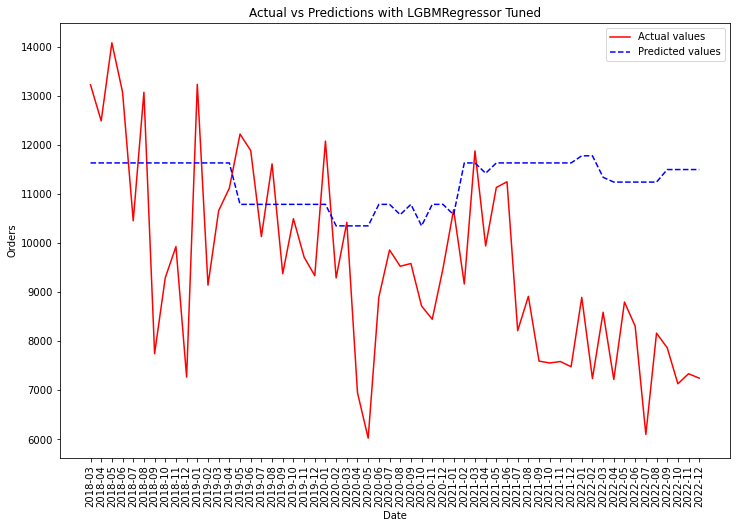

In [21]:
# Create the fnal LightGBM Model
model_tuned = LGBMRegressor(n_estimators = 100,
                         num_leaves= 3,
                         max_depth = 4,                         
                         subsample = 0.0001,
                         learning_rate= 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### Random Forest Regression

#### Baseline

RandomForestRegressor Model Performance:
Mean Absolute Error: 1946.4097.
Mean Squared Error: 5725966.2441.
Root Mean Squared Error: 2392.8991.
R^2 Score = -0.5187.
Mean Absolute Percentage Error: 22.4079.
Accuracy = 77.59%.


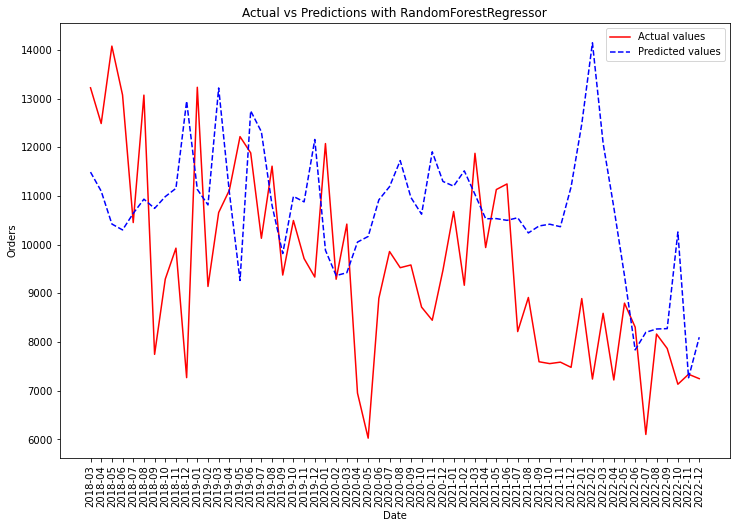

In [22]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
          
# Instantiate the regressor
model = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [23]:
model

RandomForestRegressor(random_state=42)

#### Hyperparameters Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning 
rf_n_estimators = [100, 500, 1000]
rf_max_depth = [4, 6, 8, 10]
rf_max_features = ['auto', 'sqrt']
rf_min_samples_leaf = [1, 2, 4]
rf_min_samples_split = [2, 5, 10]
rf_bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'max_features': rf_max_features,
           'min_samples_leaf': rf_min_samples_leaf,
           'min_samples_split': rf_min_samples_split,
           'bootstrap': rf_bootstrap
        }

# Tune the Model
model_base = RandomForestRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500, random_state=42)

 The best score across ALL searched params:
 -0.20213145716363534

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


#### Tuned Model

RandomForestRegressor Tuned
RandomForestRegressor Tuned Model Performance:
Mean Absolute Error: 2086.9897.
Mean Squared Error: 6185220.8372.
Root Mean Squared Error: 2487.0104.
R^2 Score = -0.6405.
Mean Absolute Percentage Error: 24.7752.
Accuracy = 75.22%.


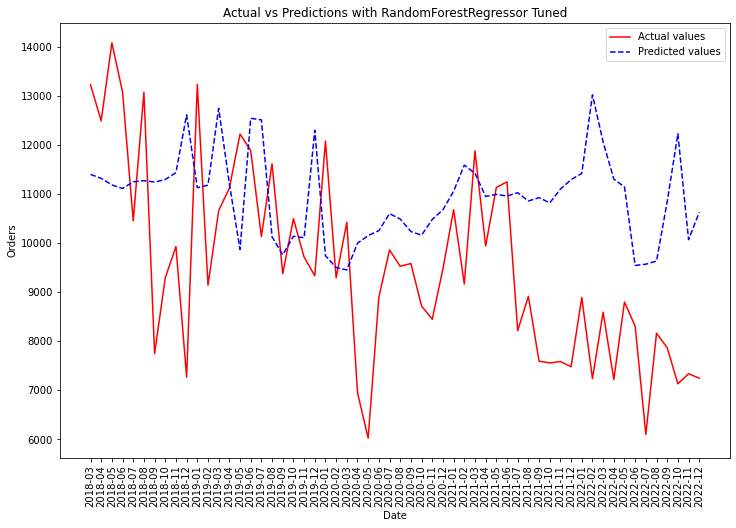

In [25]:
# Create the fnal Random Forest Regressor Model
model_tuned = RandomForestRegressor(n_estimators = 500,
                         max_depth = 4,                         
                         max_features = 'sqrt',
                         min_samples_leaf= 2,
                         min_samples_split = 5,
                         bootstrap = True,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

## Summary

In [29]:
metrics

,XGBRegressor,XGBRegressor Tuned,LGBMRegressor,LGBMRegressor Tuned,RandomForestRegressor,RandomForestRegressor Tuned
Mean Absolute Error,2.502879e+03,2.076294e+03,1.737406e+03,2.195855e+03,1.946410e+03,2.086990e+03
Mean Squared Error,9.526979e+06,6.628188e+06,4.380020e+06,6.754456e+06,5.725966e+06,6.185221e+06
Root Mean Squared Error,3.086580e+03,2.574527e+03,2.092850e+03,2.598934e+03,2.392899e+03,2.487010e+03
R^2,-1.526872e+00,-7.580161e-01,-1.617270e-01,-7.915065e-01,-5.187168e-01,-6.405264e-01
Mean Absolute Percentage Error,2.682122e+01,2.270507e+01,1.889124e+01,2.660799e+01,2.240791e+01,2.477523e+01
Accuracy,7.317878e+01,7.729493e+01,8.110876e+01,7.339201e+01,7.759209e+01,7.522477e+01


# Other tests

### XGBoost (Extreme Gradient Boosting)

XGB Model Performance:
Mean Absolute Error: 125.3602.
Mean Squared Error: 19341.8203.
Root Mean Squared Error: 139.0749.
R^2 Score = -1.3181.
Mean Squared Log Error: 0.2011.
Root Mean Squared Log Error: 0.4484.
Mean Absolute Percentage Error: 50.9709.
Accuracy = 49.03%.


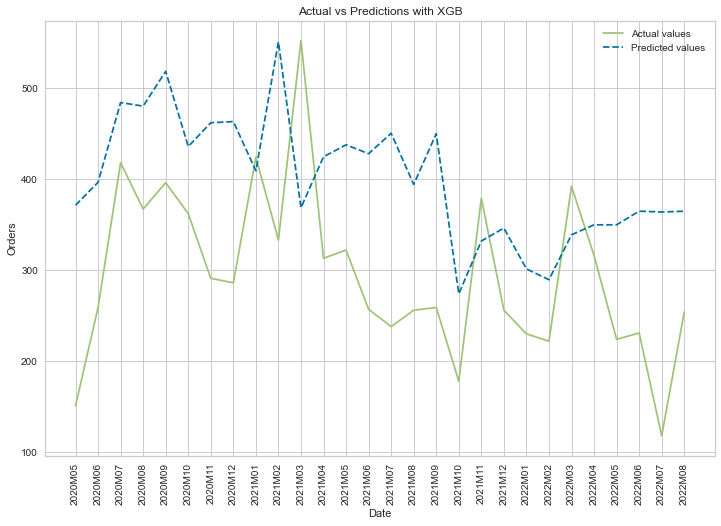

In [95]:
import xgboost as xgb
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring("XGB", xgb, X_test, y_test)

In [97]:
xgb.feature_importances_

array([0.18910074, 0.07774591, 0.24029268, 0.19292125, 0.17414135,
       0.12579808], dtype=float32)

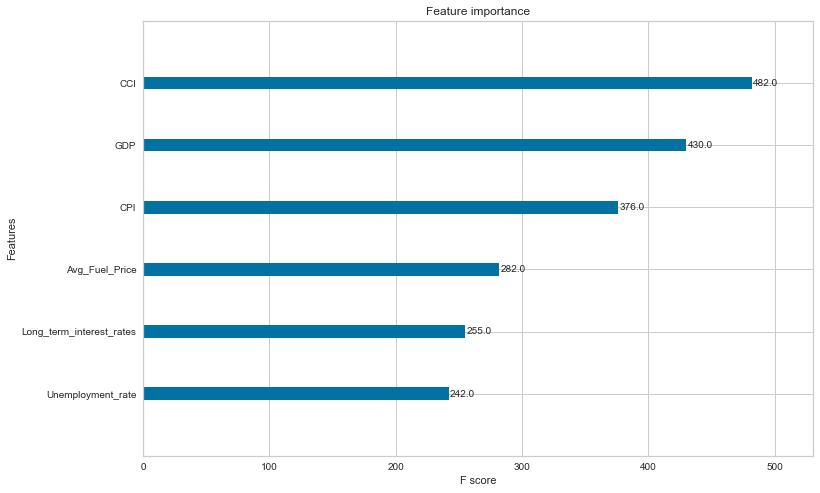

In [100]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(xgb, ax=ax)
plt.show();

### Cross-validation

In [129]:
from sklearn.model_selection import cross_val_score
import numpy as np
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[model.__class__.__name__] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Create the models to be tested
mlgbm = lgbm.LGBMRegressor()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

#models = [mlgbm, rf_reg, xgb_reg]
models = [mlgbm, rf_reg, xgb_reg]

# Run the 10 Fold Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train, y_train, 10)

comp

,LGBMRegressor,RandomForestRegressor,XGBRegressor
Mean Absolute Error,124.9471,134.5706,161.1689
Mean Squared Error,29062.9648,32277.8150,45928.3848
R^2,-0.2887,-0.6835,-1.3528
Accuracy,79.5900,78.0181,73.6733


In [130]:
# Run the 10 Fold Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_test, y_test, 10)

comp

,LGBMRegressor,RandomForestRegressor,XGBRegressor
Mean Absolute Error,78.6376,76.5052,80.8159
Mean Squared Error,9373.3210,11176.1533,11033.4681
R^2,-48.6369,-18.5144,-91.4678
Accuracy,73.4204,74.1412,72.6841


In [154]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4','Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10'])
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),len(r2s[0]))
r2_comp

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Average
LGBMRegressor,-0.0411,-34.9720,-0.4391,-1.1460,-0.5366,-3.7529,-0.0168,-0.0519,-442.3857,-3.0270,-48.63691
RandomForestRegressor,-1.6081,-3.0115,-0.3575,-1.3502,0.1843,-6.6921,-1.4051,-1.7937,-168.2067,-0.9031,-18.51437
XGBRegressor,-1.6404,-9.5846,-0.3193,-0.3960,-0.6744,-4.5882,-1.7584,-2.1400,-893.1388,-0.4379,-91.46780


### Hyperparameters Tuning - Random Forest

In [112]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'absolute_error']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'absolute_error'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [113]:
from sklearn.model_selection import RandomizedSearchCV
# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   58.8s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.05,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Hyperparameters Tuning - XGBoost (Extreme Gradient Boosting)

In [114]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist'
]
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.9s finished


{'tree_method': 'hist',
 'objective': 'reg:squarederror',
 'n_estimators': 600,
 'min_child_weight': 7,
 'max_depth': 16,
 'gamma': 0,
 'eta': 0.5}

### Final Evaluation

In [117]:
# Create the final LigthGBM

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 200,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'sqrt',
                                 max_depth = 20,
                                 criterion = 'mse',
                                 bootstrap = True,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'hist',
                         objective = 'reg:squarederror',
                         n_estimators = 600,
                         min_child_weight = 7,
                         max_depth = 16,
                         gamma = 0,
                         eta = 0.5,
                         random_state = 42)

# Train the models using 80% of the original data
# LGBM goes here --
rf_final.fit(X_train, y_train)
xgb_final.fit(X_train, y_train)

# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores
    
# Run the Cross-Validation comparison with the models used in this analysis
final_models = [rf_final, xgb_final]
comp, maes, mses, r2s, accs = cv_comparison(final_models, X_train, y_train, 4)

comp

,"RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n max_depth=20, max_features='sqrt', max_leaf_nodes=None,\n max_samples=None, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=1,\n min_samples_split=2, min_weight_fraction_leaf=0.0,\n n_estimators=200, n_jobs=None, oob_score=False,\n random_state=42, verbose=0, warm_start=False)","XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False, eta=0.5,\n eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n grow_policy='depthwise', importance_type=None,\n interaction_constraints='', learning_rate=0.5, max_bin=256,\n max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\n max_depth=16, max_leaves=0, min_child_weight=7, missing=nan,\n monotone_constraints='()', n_estimators=600, n_jobs=0,\n num_parallel_tree=1, objective='reg:squarederror', ...)"
Mean Absolute Error,137.4804,151.1757
Mean Squared Error,33936.4372,41766.7069
R^2,-0.1978,-0.5325
Accuracy,77.5428,75.3056


RandomForestRegressor Model Performance:
Mean Absolute Error: 229.7393.
Mean Squared Error: 61555.7104.
Root Mean Squared Error: 248.1042.
R^2 Score = -6.3774.
Mean Squared Log Error: 0.4845.
Root Mean Squared Log Error: 0.6961.
Mean Absolute Percentage Error: 96.4181.
Accuracy = 3.58%.


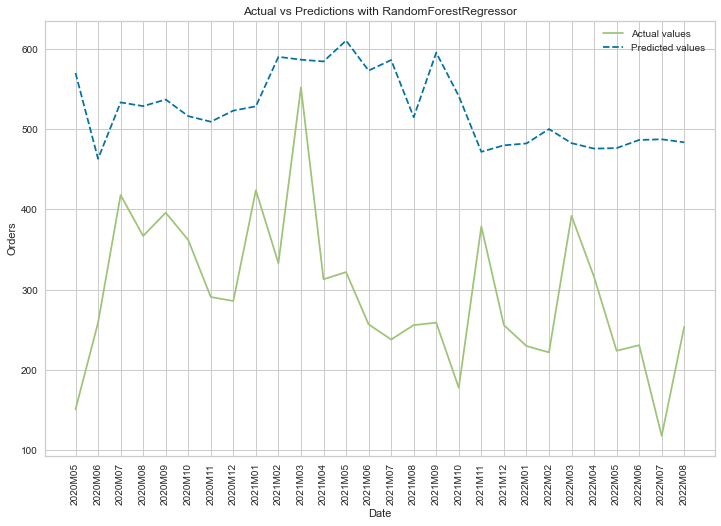

XGBRegressor Model Performance:
Mean Absolute Error: 257.3108.
Mean Squared Error: 74605.3933.
Root Mean Squared Error: 273.1399.
R^2 Score = -7.9415.
Mean Squared Log Error: 0.5269.
Root Mean Squared Log Error: 0.7259.
Mean Absolute Percentage Error: 103.8365.
Accuracy = -3.84%.


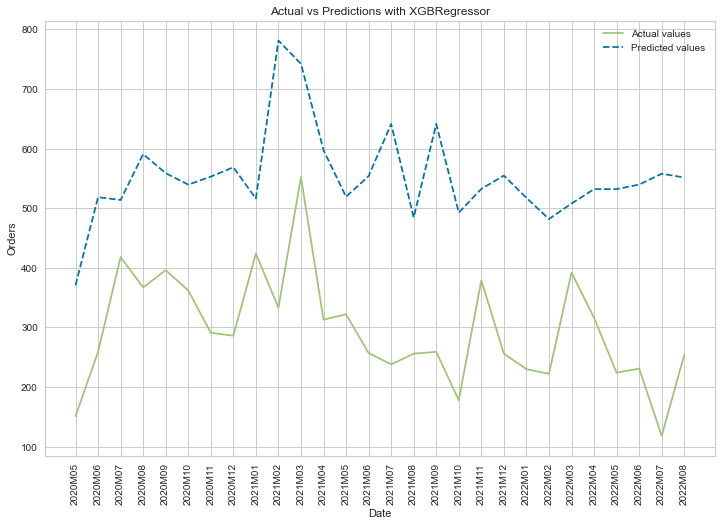

In [118]:
for model in final_models:
    scoring(model.__class__.__name__, model, X_test, y_test)

### XGBoost (Extreme Gradient Boosting)

In [119]:
import xgboost as xgb

# check xgboost version
print(xgb.__version__)

# Select input and target variables
X = data.drop(['Orders'], axis=1)
y = data["Orders"]

# Create the DMatrix 
dmatrix = xgb.DMatrix(data=X, label=y)

# Definiing params
params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization
reg_params = [1,10,100]
rmses_l1=[]

for reg in reg_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(reg_params,rmses_l1)), columns=["l1","rmse"]))

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# L2 regularization
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

1.7.2
Best rmse as a function of l1:
    l1        rmse
0    1  162.313482
1   10  158.493091
2  100  160.170547
Best rmse as a function of l2:
    l2        rmse
0    1  197.874925
1   10  219.053827
2  100  352.537560


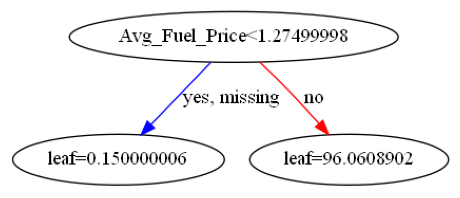

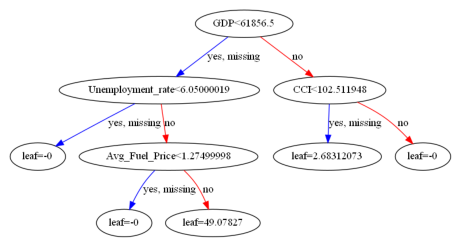

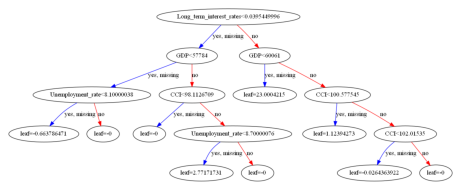

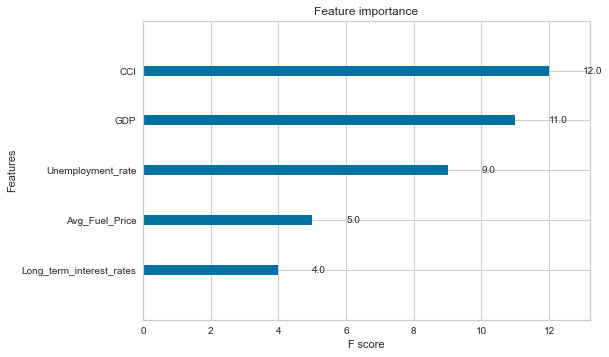

In [121]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9)
plt.show()

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

### Model tuning

In [122]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                    'n_estimators': [200],
                    'subsample': np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'subsample': 0.9500000000000001, 'n_estimators': 200, 'learning_rate': 0.8500000000000001}
Lowest RMSE found:  188.08143960338987


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.1s finished


In [28]:
# Create the DMatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds        rmse
0                    5  183.122624
1                   10  147.596829
2                   15  145.746563


In [21]:
X_train.shape, X_test.shape

((112, 13), (28, 13))

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 72.653859


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [33]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,368.897880,12.618361,368.081924,28.865079
1,337.347801,11.430440,337.864388,30.209572
2,308.618192,10.960824,309.358712,31.367627
3,282.799589,10.193485,283.653487,32.242495
4,259.745429,9.594686,261.709599,32.982860


In [34]:
print((cv_results["test-rmse-mean"]).tail(1))

32    115.488021
Name: test-rmse-mean, dtype: float64


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [22]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_tree'

In [119]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

## Choosing classifier

In [120]:
from xgboost import XGBRegressor
import xgboost as xgb
#create an xgboost regression model
model = XGBRegressor()

## Fitting the model

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

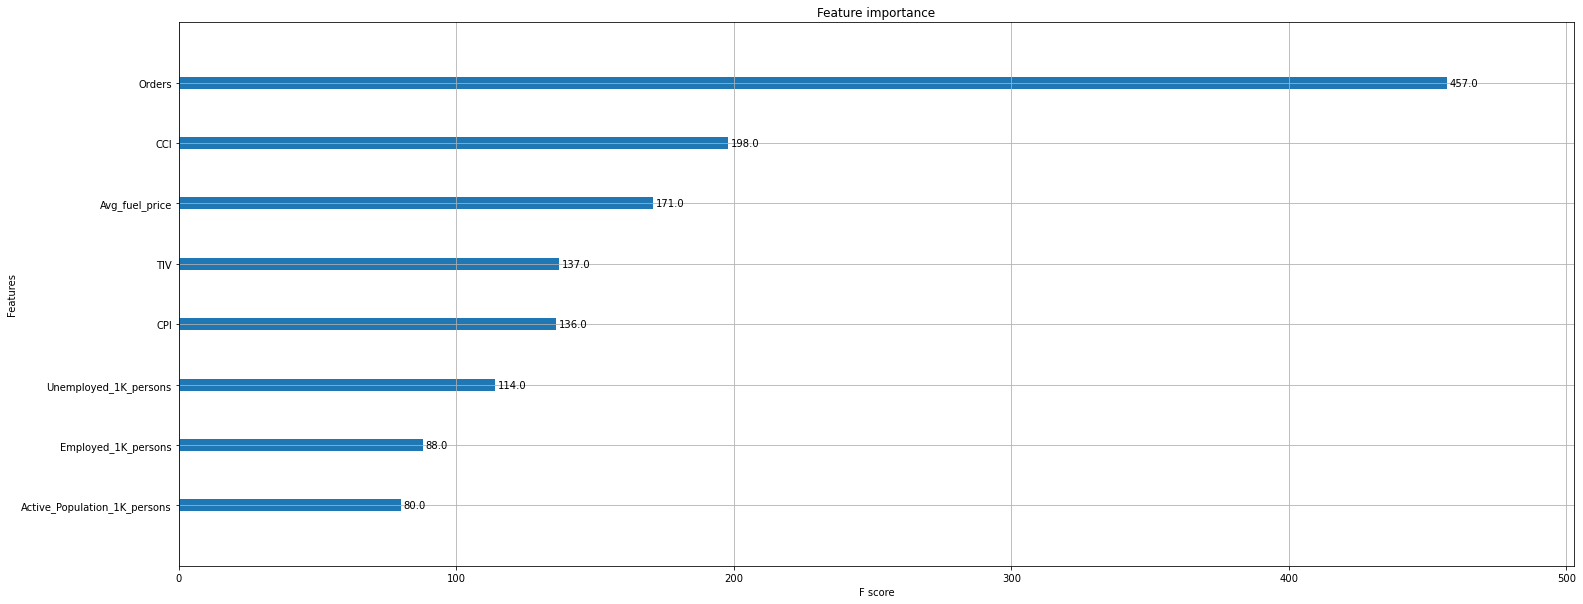

In [122]:
xgb.plot_importance(model, ax=plt.gca())

## Tuning hyperparameters

In [ ]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [26]:
# evaluate an xgboost regression model 
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# split data into input and output columns
X, y = datavalues[:, :-1], datavalues[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 20.692 (7.774)


In [51]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [52]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', \
                           n_estimators=1000, \
                          nthread=24)
reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', ...)

In [53]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 68.086
